#### Instantiate llama2 llm with langchain Ollama

In [1]:
from langchain_community.llms import Ollama

#llm = Ollama(model="llama2:13b", temperature=0.01)
llm = Ollama(model = 'dolphin-mixtral', temperature = 0.01)

#### Test that the llm works by asking it for a joke

In [2]:
print(llm.invoke('Tell me a joke'))

 Why don't scientists trust atoms? Because they make up everything!


### Set path to base directory of repo

In [2]:
import pandas as pd
import sys
from pathlib import Path
base_dir = str(Path(Path.cwd()).resolve().parent.parent)
print(base_dir)
sys.path.append(base_dir)

B:\data_science_projects\erdos_institute\aware-nlp


### Import labeler class

In [3]:
from langchain.prompts import PromptTemplate
from src.labeler.ollama import OllamaLabelerVariablePrompt

#### Display 7 human observer labeled result

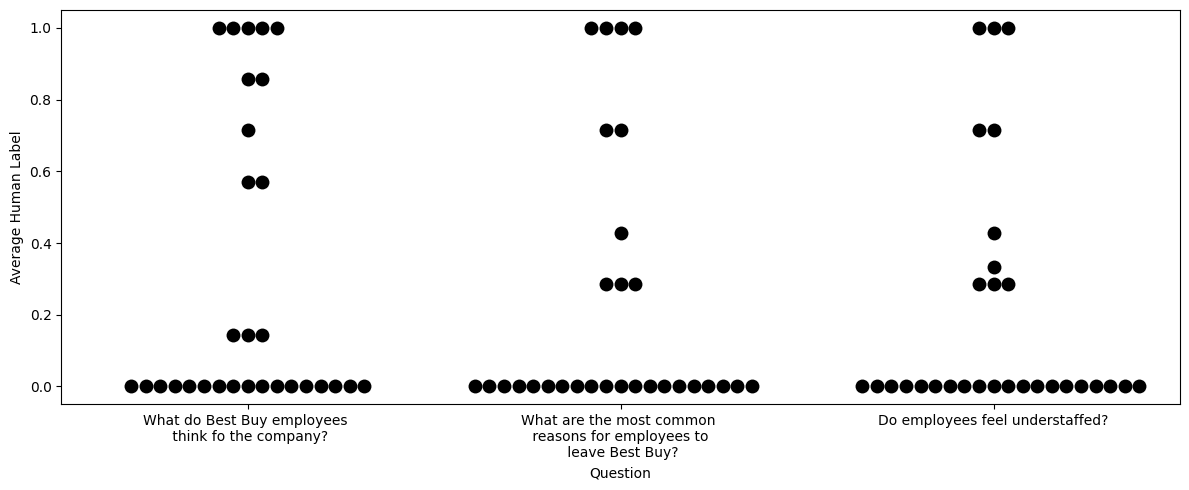

In [ ]:
import seaborn as sns

def wrap_text(text, n_words = 5):
    sent = text.split(' ')
    for i in range(n_words, len(sent), n_words):
        sent.insert(i, '\n')
    return ' '.join(sent)
temp_df['Question'] = temp_df['question'].apply(wrap_text)
label_colors = {1: 'royalblue', 0: 'firebrick'}

f = plt.figure(figsize=(12,5))
sns.swarmplot(
    x = 'Question', 
    y = 'average_label', 
    data = temp_df.rename(columns = {'relevant':'LLM Label'}),  
    legend = "auto", 
    #palette=label_colors,
    edgecolor='black',
    color='k',
    s=10,
    )
plt.ylabel('Average Human Label')
#plt.axhline(y=2/7, color='black', linestyle='--')
f.tight_layout()
f.savefig('../../figures/bestbuy_human_labels.png')

#### Define Prompts to instruct the llm to label relevance

In [ ]:
prompt_dict = {
    0: """<s>[INST] <<SYS>>
            The following statement (delimited by ```) provided below is a response from an employee at the company of interest. 
            The statement should be taken as is. It cannot be used to further a dialogue with the employee. 
            
            Please format the output as a dictionary with the following keys: "relevant", "reason". 
            Relevant should be a boolean value indicating whether the statement is relevant to the question.
            Reason should be a string explaining why and how the statement is or is not relevant.
            <</SYS>>
            Does the statement below help answer the question: {question}
            ```
            Statement: {statement}
            ```
            [/INST]""",
    1: """<s>[INST] <<SYS>>
            The following statement (delimited by ```) provided below is a response from an employee at the company of interest. 
            The statement should be taken as is. It cannot be used to further a dialogue with the employee. 
            The statement should be labeled as relevant (true) if it provides an account (positive, negative, or neutral) 
            that helps answer the question.

            Please format the output as a dictionary with the following keys: "relevant", "reason". 
            Relevant should be a boolean value indicating whether the statement is relevant to the question.
            Reason should be a string explaining why and how the statement is or is not relevant.
            <</SYS>>
            Does the statement below help answer the question: {question}
            ```
            Statement: {statement}
            ```
            [/INST]"""

}

## Label Samples with prompt index 1

In [8]:
from typing import Dict, Any
from src.labeler.ollama import OllamaLabelerVariablePrompt, PromptTemplate
import time
from datetime import timedelta
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
import seaborn as sns

def wrap_text(text, n_words: int = 5, indent: str = ''):
    sent = text.split(' ')
    for i in range(n_words, len(sent), n_words):
        sent.insert(i, '\n'+indent)
    return ' '.join(sent)

def print_labeler_iteration(question: str, statement: str, out: Dict[str, Any]):
    question = wrap_text(question, n_words = 20,indent="\t")
    statement = wrap_text(statement, n_words = 20,indent="\t")
    print(f'\n{"--"*30}\nQuestion: {question}')
    print(f'Statement: {statement}')

    rel = out.get('relevant')
    reason = wrap_text(out.get('reason'), n_words = 20, indent = '\t\t')
    raw_output = wrap_text(out.get('output'), n_words = 20, indent='\t')

    print_statement = 'Output: '
    print_statement += f'{raw_output}' if rel is None else f'\n\tRelevant: {rel}\n\tReason: {reason}'
    print(print_statement)

def label_samples(labeler: OllamaLabelerVariablePrompt, sample_file_path: str, save_file_path: str):
    sample_df = pd.read_csv(sample_file_path)
    sample_data = []
    for i, row in sample_df.iterrows():
        question = row['question']
        statement = row['statement']

        t0 = time.time()
        out = labeler.evaluate_one(question, statement)
        sample_data.append((out | row.to_dict()))
        t1 = time.time()

        print_labeler_iteration(question, statement, out)
        print(f'...took {timedelta(seconds=(t1-t0))}')
        pd.DataFrame(sample_data).to_csv(save_file_path, index=False)


def plot_llm_labeling_performance(pred_filepath: str, labeled_filepath: str, llm_model_name: str, template_index: int, consensus_threshold: float = 0.5):
    pred_df = pd.read_csv(pred_filepath)
    labelled_dataset = pd.read_csv(labeled_filepath)

    temp_df = pred_df.merge(labelled_dataset, on=['question','statement'])
    temp_df = temp_df.dropna(subset=['relevant'])
    temp_df['relevant'] = temp_df['relevant'].astype(int)
    temp_df['consensus'] = (temp_df['average_label'] > consensus_threshold).astype(int)
    temp_df['Question'] = temp_df['question'].apply(wrap_text)
    label_colors = {1: 'royalblue', 0: 'firebrick'}

    f = plt.figure(figsize=(18,5))
    sns.swarmplot(
        x = 'Question', 
        y = 'average_label', 
        data = temp_df.rename(columns = {'relevant':'LLM Label'}), 
        hue = 'LLM Label', 
        legend = "auto", 
        palette=label_colors,
        edgecolor='black',
        s=10,
        )
    plt.ylabel('Average Human Label')
    plt.axhline(y=0.5, color='black', linestyle='--')

    plt.title(f"Model: {llm_model_name}, Prompt Template {template_index}; f1: {f1_score(temp_df['consensus'],temp_df['relevant'].astype(int)):.2f}")
    f.savefig(f'../../figures/labeling/{llm_model_name}_prompt{template_index}.png')


------------------------------------------------------------
Question: What do Best Buy employees think fo the company?
Statement: What is your opinion on Best Buy currently.
Output: 
	Relevant: False
	Reason: The provided statement does not offer any information about what Best Buy employees think of the company.
...took 0:02:03.567636

------------------------------------------------------------
Question: What do Best Buy employees think fo the company?
Statement: Why are you at Best Buy?
Output: 
	Relevant: False
	Reason: The statement 'Why are you at Best Buy?' does not provide any account or opinion about what Best Buy employees 
		 think of the company. It is a question asking for the reason why someone is working at Best Buy.
...took 0:01:10.037555

------------------------------------------------------------
Question: What do Best Buy employees think fo the company?
Statement: Don’t listen to this guy, I work there and the team environment is outstanding everyone stands around

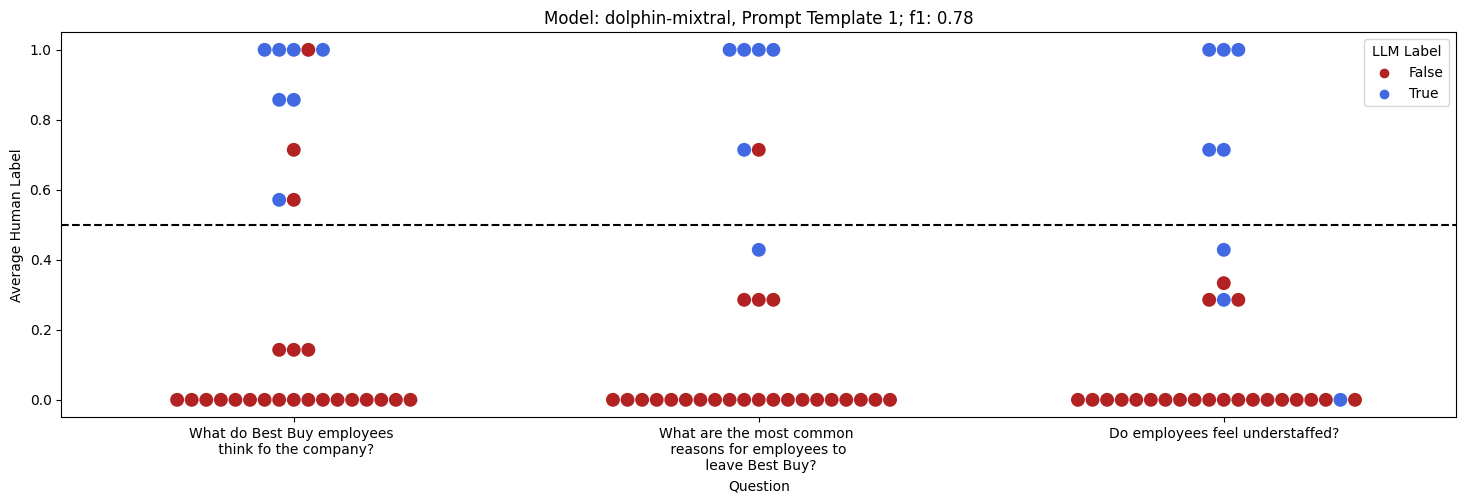

In [72]:

# Set parameters and define filenames/paths
llm_model_name = 'dolphin-mixtral'
prompt_template_idx = 1
sample_filename = '../../data/best_buy/sample_questions_statements.csv'
save_filename = f'../../data/best_buy/labeling/labeled_samples_{llm_model_name}_prompt_template{prompt_template_idx}.csv'
labeled_dataset_filename = '../../data/best_buy/evaluation_set.csv'

# Run automated labeling 
llm = Ollama(model=llm_model_name, temperature=0.01)
prompt = PromptTemplate(template=prompt_dict[prompt_template_idx], input_variables=["statement", "question"])
labeler = OllamaLabelerVariablePrompt(llm, prompt)
label_samples(labeler, sample_filename, save_filename)

# Plot performance of automated labeling
pred_filename = save_filename
plot_llm_labeling_performance(pred_filename, labeled_dataset_filename, llm_model_name, prompt_template_idx)

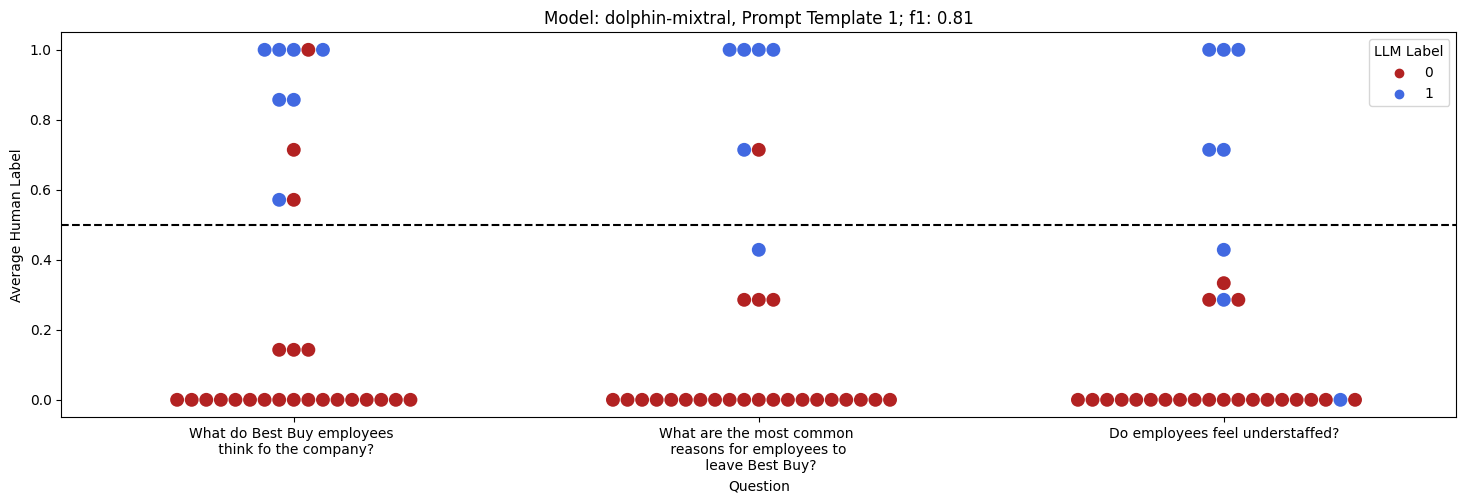

In [74]:

plot_llm_labeling_performance(pred_filename, labeled_dataset_filename, llm_model_name, prompt_template_idx)

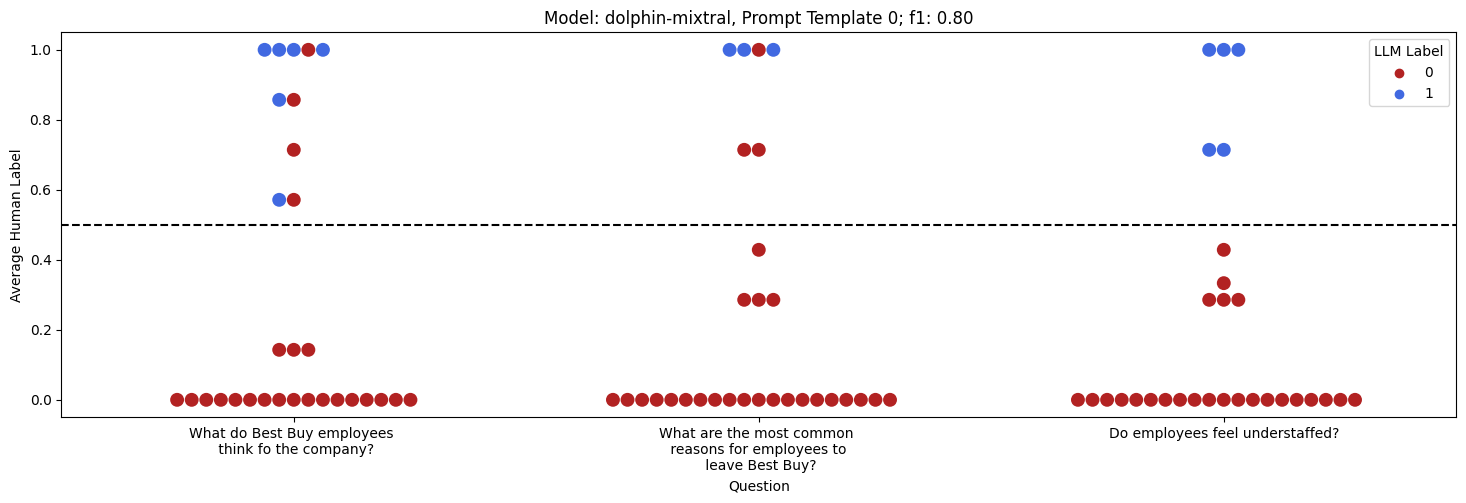

In [9]:

llm_model_name = 'dolphin-mixtral'
prompt_template_idx = 0
sample_filename = '../../data/best_buy/sample_questions_statements.csv'
save_filename = f'../../data/best_buy/labeling/labeled_samples_{llm_model_name}_prompt_template{prompt_template_idx}.csv'
labeled_dataset_filename = '../../data/best_buy/evaluation_set.csv'
pred_filename = save_filename
plot_llm_labeling_performance(pred_filename, labeled_dataset_filename, llm_model_name, prompt_template_idx)

#### Plot results with new prompt template

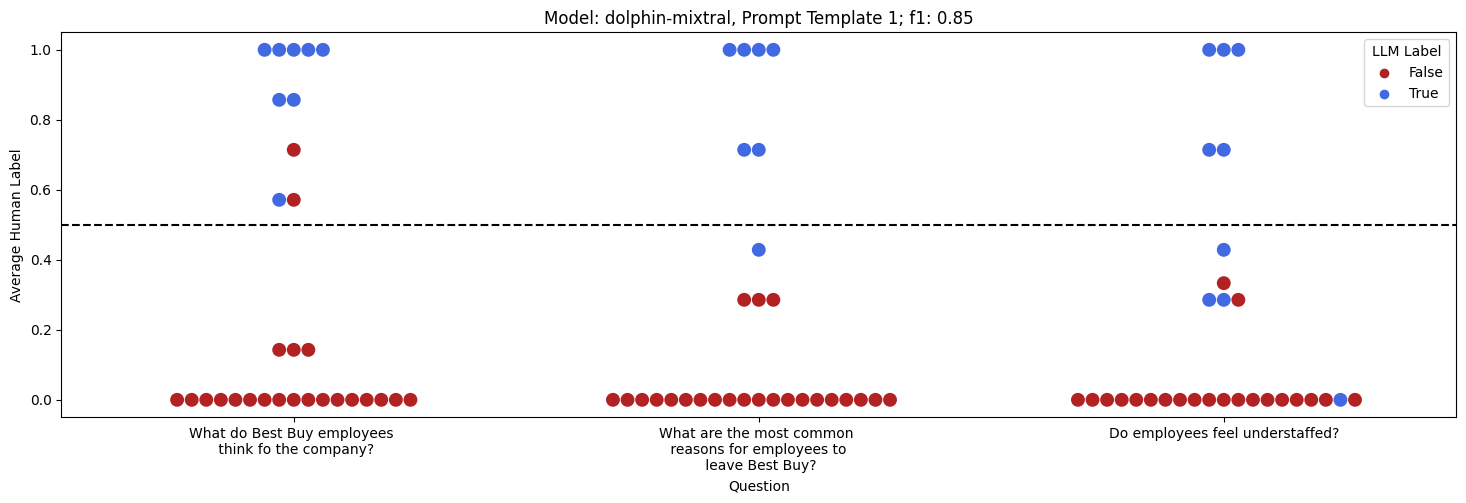

In [58]:
import seaborn as sns
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.metrics import f1_score

pred_filename = '../../data/best_buy/labeling/labeled_samples_dolphin-mixtral_prompt_template1.csv'
labeled_dataset_filename = '../../data/best_buy/evaluation_set.csv'


def wrap_text(text, n_words = 5, indent = ''):
    sent = text.split(' ')
    for i in range(n_words, len(sent), n_words):
        sent.insert(i, '\n'+indent)
    return ' '.join(sent)

def plot_llm_labeling_performance(pred_filepath: str, labeled_filepath: str, llm_model_name: str, template_index: int):
    pred_df = pd.read_csv(pred_filepath)
    labelled_dataset = pd.read_csv(labeled_filepath)

    temp_df = pred_df.merge(labelled_dataset, on=['question','statement'])
    temp_df['relevant'].astype(int).corr(temp_df['average_label'])

    temp_df['Question'] = temp_df['question'].apply(wrap_text)
    label_colors = {1: 'royalblue', 0: 'firebrick'}

    f = plt.figure(figsize=(18,5))
    sns.swarmplot(
        x = 'Question', 
        y = 'average_label', 
        data = temp_df.rename(columns = {'relevant':'LLM Label'}), 
        hue = 'LLM Label', 
        legend = "auto", 
        palette=label_colors,
        edgecolor='black',
        s=10,
        )
    plt.ylabel('Average Human Label')
    plt.axhline(y=0.5, color='black', linestyle='--')

    plt.title(f"Model: {llm_model_name}, Prompt Template {template_index}; f1: {f1_score(temp_df['consensus'],temp_df['relevant']):.2f}")
    f.savefig(f'../../figures/labeling/{llm_model_name}_prompt{template_index}.png')

pred_filename = '../../data/best_buy/labeling/labeled_samples_dolphin-mixtral_prompt_template1.csv'
labeled_dataset_filename = '../../data/best_buy/evaluation_set.csv'
plot_llm_labeling_performance(pred_filename, labeled_dataset_filename, 'dolphin-mixtral', 1)

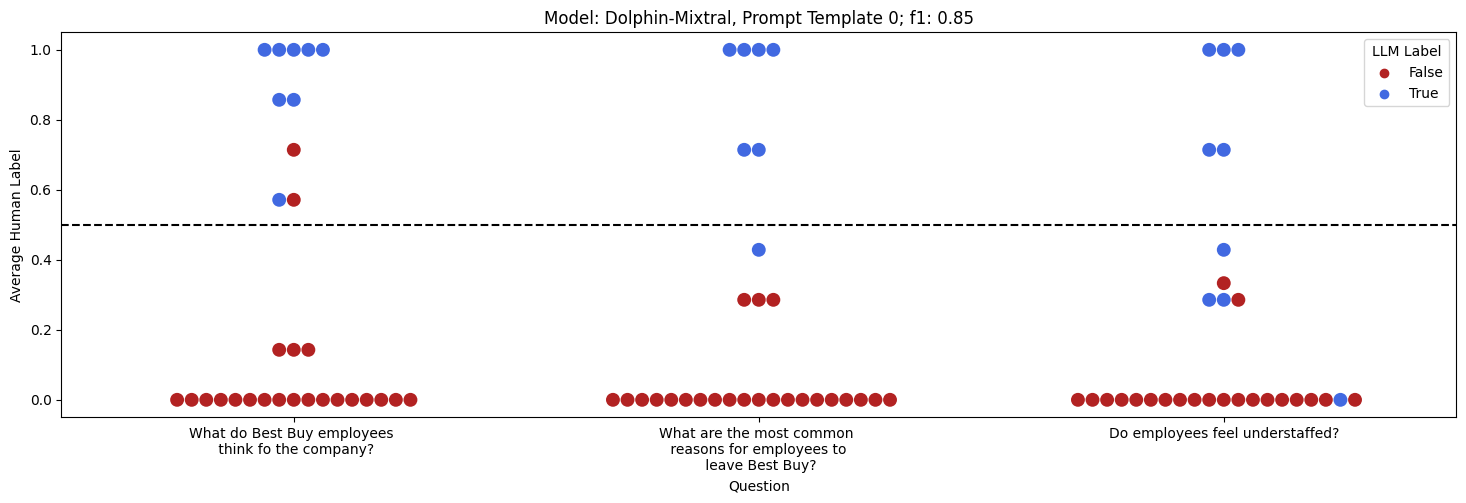

In [54]:
import seaborn as sns
import pandas as pd
from matplotlib import pyplot as plt

pred_filename = '../../data/best_buy/labeling/labeled_samples_dolphin-mixtral_prompt_template1.csv'

#samples_df = pd.read_csv('../../data/best_buy/sample_questions_statements.csv')
pred_df = pd.read_csv(pred_filename)
labelled_dataset = pd.read_csv('../../data/best_buy/evaluation_set.csv')

temp_df = pred_df.merge(labelled_dataset, on=['question','statement'])
temp_df['relevant'].astype(int).corr(temp_df['average_label'])

def wrap_text(text, n_words = 5, indent = ''):
    sent = text.split(' ')
    for i in range(n_words, len(sent), n_words):
        sent.insert(i, '\n'+indent)
    return ' '.join(sent)
temp_df['Question'] = temp_df['question'].apply(wrap_text)
label_colors = {1: 'royalblue', 0: 'firebrick'}

f = plt.figure(figsize=(18,5))
sns.swarmplot(
    x = 'Question', 
    y = 'average_label', 
    data = temp_df.rename(columns = {'relevant':'LLM Label'}), 
    hue = 'LLM Label', 
    legend = "auto", 
    palette=label_colors,
    edgecolor='black',
    s=10,
    )
plt.ylabel('Average Human Label')
plt.axhline(y=0.5, color='black', linestyle='--')

from sklearn.metrics import f1_score
plt.title(f"Model: Dolphin-Mixtral, Prompt Template 0; f1: {f1_score(temp_df['consensus'],temp_df['relevant']):.2f}")
f.savefig('../../figures/labeling/dolphin-mixtral_prompt0.png')